In [1]:
from nba_api.stats.endpoints import playbyplayv2, leaguegamefinder
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
games = leaguegamefinder.LeagueGameFinder(league_id_nullable='00').get_data_frames()[0]

In [7]:
games.head(10)

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,22021,1610612762,UTA,Utah Jazz,0022100492,2021-12-25,UTA vs. DAL,W,240,120,...,0.757,13,36,49,24,9,6,14,24,4.0
1,22021,1610612742,DAL,Dallas Mavericks,0022100492,2021-12-25,DAL @ UTA,L,242,116,...,0.857,8,35,43,19,7,3,13,31,-4.0
2,22021,1610612738,BOS,Boston Celtics,0022100489,2021-12-25,BOS @ MIL,L,240,113,...,0.833,11,33,44,24,9,8,14,23,-4.0
3,22021,1610612749,MIL,Milwaukee Bucks,0022100489,2021-12-25,MIL vs. BOS,W,241,117,...,0.704,15,33,48,24,7,6,13,20,4.0
4,22021,1610612737,ATL,Atlanta Hawks,0022100488,2021-12-25,ATL @ NYK,L,241,87,...,0.571,8,38,46,23,8,5,12,12,-14.0
5,22021,1610612752,NYK,New York Knicks,0022100488,2021-12-25,NYK vs. ATL,W,240,101,...,0.417,9,41,50,28,6,6,10,13,14.0
6,22021,1610612756,PHX,Phoenix Suns,0022100490,2021-12-25,PHX vs. GSW,L,241,107,...,1.000,9,28,37,20,5,2,13,17,-9.0
7,22021,1610612744,GSW,Golden State Warriors,0022100490,2021-12-25,GSW @ PHX,W,239,116,...,0.857,12,30,42,28,11,7,9,22,9.0
8,22021,1610612751,BKN,Brooklyn Nets,0022100491,2021-12-25,BKN @ LAL,W,241,122,...,0.815,6,35,41,31,6,10,10,25,7.0
9,22021,1610612747,LAL,Los Angeles Lakers,0022100491,2021-12-25,LAL vs. BKN,L,240,115,...,0.893,12,35,47,29,8,5,13,23,-7.0


In [3]:
from datetime import datetime

def str_to_time(str1):
    time_ = datetime.strptime(str1, "%M:%S")
    return time_.second + time_.minute*60


def home_poss(d):
    if (d['home_true'] == 1) & (d['visitor_true']==0):
        return 1
    elif (d['home_true'] == 0) & (d['visitor_true']==1):
        return 0
    else:
        if d['block'] or d['steal']:
            return 1
        else:
            return 0
        
def find_seconds_left(x):
    if x == 1:
        return 3*720
    elif x == 2: 
        return 2*720
    elif x == 3:
        return 720
    else:
        return 0

def load_game(game_id):
    pbp = playbyplayv2.PlayByPlayV2(game_id).get_data_frames()[0]
    home_team_name = pbp['PLAYER1_TEAM_ABBREVIATION'].dropna().iloc[0]
    return pbp, home_team_name

def feature_engineer(pbp):
    pbp[['home_true', 'visitor_true']] = pbp[['HOMEDESCRIPTION','VISITORDESCRIPTION']].notnull().astype(int)
    pbp['block'] = pbp['HOMEDESCRIPTION'].str.contains("BLOCK").fillna(False)
    pbp['steal'] = pbp['HOMEDESCRIPTION'].str.contains("STEAL").fillna(False)

    pbp['home_poss'] = pbp.apply(home_poss, axis = 1)
    pbp['diff'] = pbp['SCOREMARGIN'].ffill().fillna(0).replace({'TIE':0}).astype(int)
    pbp['OT_ind'] = (pbp['PERIOD']-4).clip(lower=0)

    pbp['seconds'] = pbp['PCTIMESTRING'].apply(str_to_time)
    pbp['seconds_left_in_game_from_quarter'] = pbp['PERIOD'].apply(find_seconds_left)
    pbp['time_remaining'] = pbp['seconds'] + pbp['seconds_left_in_game_from_quarter']

    game = pbp[['home_poss', 'OT_ind', 'diff', 'time_remaining']]
    
    return game

def adjust_time(pbp):
    final = pd.DataFrame(data = pd.Index(range(2880,-1,-1)), columns=['time_remaining'])

    final = final.merge(pbp, on=['time_remaining'], how='left').ffill()

    final = final[final['time_remaining'].isin(range(0,2883,3))]

    final = final.set_index('time_remaining')
    final = final[['home_poss', 'diff', 'OT_ind']]
    return final

def predict(df, models):
    probs = []
    for time in df.index.unique():
        v = df.loc[time].values
        if len(v.shape) == 1:
            v = v.reshape(1,-1)
        probs.append(models[time].predict_proba(v))
        
    df[['home_lose_prob', 'home_win_prob']] = np.concatenate(probs)
    df['time'] = 2880 - df.index
    return df

def get_win_graph(game_id, models):
    game, home_team_name = load_game(game_id)
    game = feature_engineer(game)
    game = adjust_time(game)
    game = predict(game, models)
    
    game.plot(kind='line', x = 'time', y='home_win_prob', title=f'prob of {home_team_name} winning', figsize=(20,16))
    plt.show()
    return game

In [4]:
with open('../Models/baseline_logisitc.pkl', 'rb') as file:
    models = pickle.load(file)

In [5]:
games.head(10)

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,PTS,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PF,PLUS_MINUS
0,22021,1610612762,UTA,Utah Jazz,0022100492,2021-12-25,UTA vs. DAL,W,240,120,...,0.757,13,36,49,24,9,6,14,24,4.0
1,22021,1610612742,DAL,Dallas Mavericks,0022100492,2021-12-25,DAL @ UTA,L,242,116,...,0.857,8,35,43,19,7,3,13,31,-4.0
2,22021,1610612738,BOS,Boston Celtics,0022100489,2021-12-25,BOS @ MIL,L,240,113,...,0.833,11,33,44,24,9,8,14,23,-4.0
3,22021,1610612749,MIL,Milwaukee Bucks,0022100489,2021-12-25,MIL vs. BOS,W,241,117,...,0.704,15,33,48,24,7,6,13,20,4.0
4,22021,1610612737,ATL,Atlanta Hawks,0022100488,2021-12-25,ATL @ NYK,L,241,87,...,0.571,8,38,46,23,8,5,12,12,-14.0
5,22021,1610612752,NYK,New York Knicks,0022100488,2021-12-25,NYK vs. ATL,W,240,101,...,0.417,9,41,50,28,6,6,10,13,14.0
6,22021,1610612756,PHX,Phoenix Suns,0022100490,2021-12-25,PHX vs. GSW,L,241,107,...,1.000,9,28,37,20,5,2,13,17,-9.0
7,22021,1610612744,GSW,Golden State Warriors,0022100490,2021-12-25,GSW @ PHX,W,239,116,...,0.857,12,30,42,28,11,7,9,22,9.0
8,22021,1610612751,BKN,Brooklyn Nets,0022100491,2021-12-25,BKN @ LAL,W,241,122,...,0.815,6,35,41,31,6,10,10,25,7.0
9,22021,1610612747,LAL,Los Angeles Lakers,0022100491,2021-12-25,LAL vs. BKN,L,240,115,...,0.893,12,35,47,29,8,5,13,23,-7.0


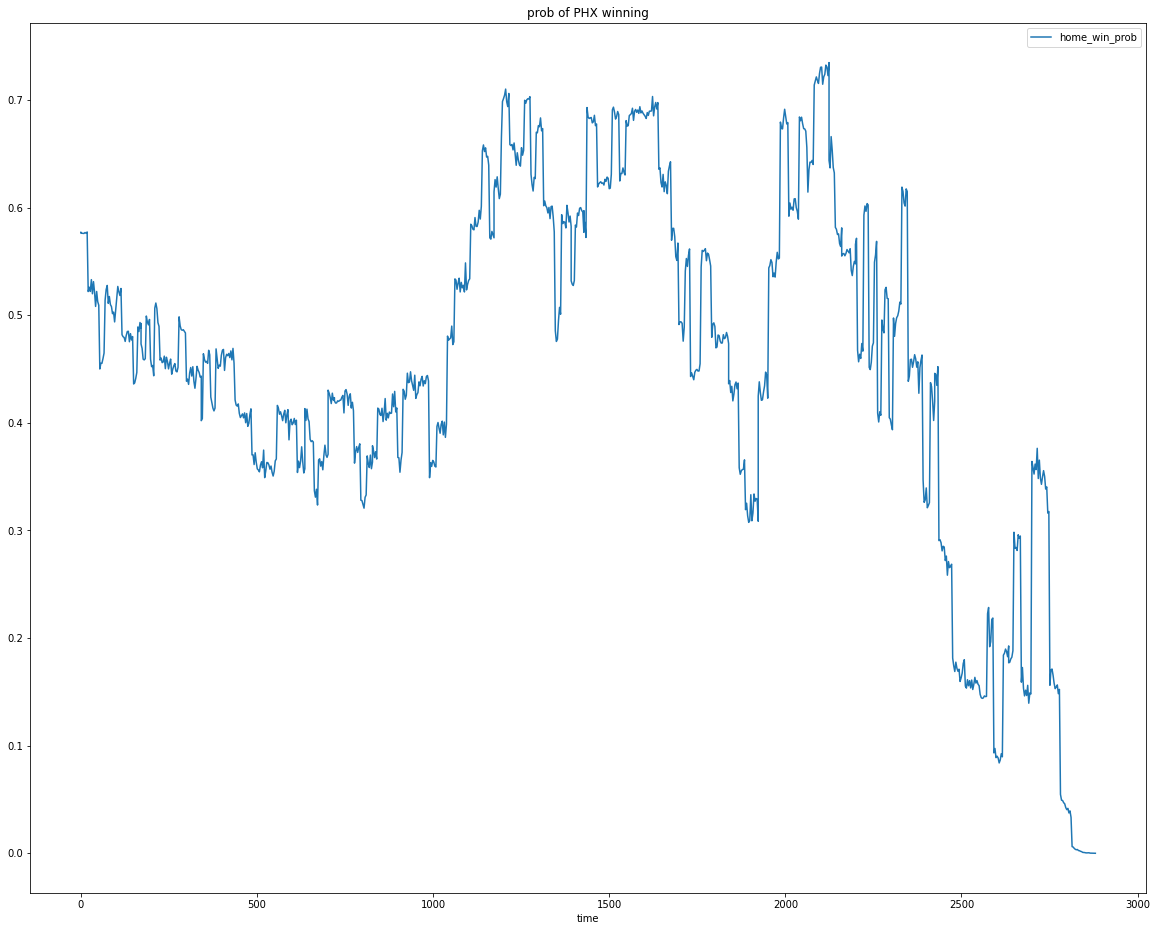

,home_poss,diff,OT_ind,home_lose_prob,home_win_prob,time
time_remaining,,,,,,
2880,0.0,0.0,0.0,0.423515,5.764848e-01,0
2880,1.0,0.0,0.0,0.422919,5.770807e-01,0
2877,1.0,0.0,0.0,0.423924,5.760757e-01,3
2874,1.0,0.0,0.0,0.423988,5.760115e-01,6
2871,1.0,0.0,0.0,0.424121,5.758793e-01,9
...,...,...,...,...,...,...
12,0.0,-9.0,0.0,0.999873,1.270379e-04,2868
9,0.0,-9.0,0.0,0.999958,4.191074e-05,2871
6,0.0,-9.0,0.0,0.999958,4.165833e-05,2874


In [8]:
get_win_graph('0022100490', models)
